__Dependencies__

In [4]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Lock, Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options and constants__

In [5]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "darkgrid"
sns.set_style(STYLE)  # set seaborn plotting style

PATH_RAYC = "./data/raw/CsvData"
PATH_PROC = "./data/processed"

# hit origin structure (parsed/new)
HIT_ORIGIN = [
    "frame",
    "originX",
    "originY",
    "originZ",
    "rotationX",
    "rotationY",
    "rotationZ",
    "rotationW",
    "directionX",
    "directionY",
    "directionZ",
    "angleX",
    "angleY",
    "angleZ",
]

# hit information structure (all objects)
HIT_INFO = [
    "frame",
    "name",
    "group",
    "distance",
    "objectX",
    "objectY",
    "objectZ",
    "hitX",
    "hitY",
    "hitZ",
]

# x, y, and z axis direction vectors
X_DIR = np.array([1, 0, 0])
Y_DIR = np.array([0, 1, 0])
Z_DIR = np.array([0, 0, 1])

# hit groups to skip
EXCEPT_GROUPS = ["End", "Events", "Start"]

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [6]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)


def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)


def parse_cordinates(cords):
    """
    Get N cordinate values given the string representation "(x, y, z, w...)".

    Parameters:
        cords (string): Cordinates expressed as (x, y, z, w...)
    Returns:
        list: Parsed cordinates, N float values.
    """
    # remove parenthesis from string
    cords = cords.replace("(", "").replace(")", "")
    # split string by comma, cast values as floats
    return [float(v) for v in cords.split(",")]

__Read participants cleaned data__

In [7]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire,nulls_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,6.739
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.225
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,46.237
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,8.049
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,26.881
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,34.182
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,7.413
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,7.151


Participant data example to process

In [8]:
selected = parts.iloc[0]
uid = pd.Index(selected).name

file = f"Path_ MS Wissenschaft-{selected.condition}-{uid}.csv"
df = pd.read_csv(f"{PATH_RAYC}/{file}")
df = df.set_index("frameNumber")
df

,trackerPosition,trackerRotation,noseVector,hitObjectNames,hitObjectPositions,hitPositionOnObjects,hitObjectGroups
frameNumber,,,,,,,
400,"(-193.8, 102.3, -131.8)","(0.0, 0.7, 0.1, 0.7)","(1.0, 0.2, 0.1)",Start,"(-166.9, 99.11023, -132)","(-177.7123, 104.7654, -130.4461)",Start
401,"(-193.8, 102.3, -131.8)","(0.0, 0.7, 0.1, 0.7)","(1.0, 0.2, 0.1)",Start,"(-166.9, 99.11023, -132)","(-177.7123, 104.8219, -130.527)",Start
402,"(-193.8, 102.3, -131.8)","(0.0, 0.7, 0.1, 0.7)","(1.0, 0.2, 0.1)",Start,"(-166.9, 99.11023, -132)","(-177.7123, 104.7937, -130.5624)",Start
403,"(-193.7, 102.3, -131.8)","(0.0, 0.7, 0.1, 0.7)","(1.0, 0.2, 0.1)",Start,"(-166.9, 99.11023, -132)","(-177.7123, 104.7296, -130.5805)",Start
404,"(-193.7, 102.3, -131.8)","(0.0, 0.7, 0.1, 0.7)","(1.0, 0.2, 0.1)",Start,"(-166.9, 99.11023, -132)","(-177.7123, 104.6884, -130.6121)",Start
...,...,...,...,...,...,...,...
3066,"(-41.4, 102.2, -199.3)","(0.0, 0.8, 0.0, -0.7)","(-1.0, 0.0, -0.1)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-89.89999, 122.5, -220.3999)","(-71.96298, 102.2121, -203.7472)",WestRide Buildings
3067,"(-41.7, 102.2, -199.3)","(0.0, 0.8, 0.0, -0.7)","(-1.0, 0.0, -0.1)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-89.89999, 122.5, -220.3999)","(-71.96298, 102.2188, -203.4849)",WestRide Buildings
3068,"(-41.9, 102.2, -199.3)","(0.0, 0.8, 0.0, -0.7)","(-1.0, 0.0, -0.1)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-89.89999, 122.5, -220.3999)","(-71.96298, 102.2288, -203.3641)",WestRide Buildings


In [12]:
def process_hits(uid):
    """
    Process raw raycasted hit data as hit origin and information
    separately given a participant UID:

    - Disentangle origin and direction coordinates
    - Disentangle object and group names
    - Calculate direction (nose vector) angles and hit distances
    - Order object hits within the same frame by distance
    - Rename/rearrange object groups
    - Fix objects belonging to wrong group
    - Store as processed hit origin and hit info

    Parameters:
        uid (str): Participant UID to process.
    """

    cond = parts.loc[uid].condition
    file = f"Path_ MS Wissenschaft-{cond}-{uid}.csv"
    df_part = pd.read_csv(f"{PATH_RAYC}/{file}", keep_default_na=False)

    # generate the new dict (=> dataFrame) structure
    orgs = {c: [] for c in HIT_ORIGIN}
    hits = {c: [] for c in HIT_INFO}

    # df indices (all frames)
    frames = df_part.index.tolist()

    for f in frames:  # iterate over frames

        cur = df_part.loc[f]  # current row (frame)
        # parse and store origin
        origin = cur.trackerPosition
        origX, origY, origZ = parse_cordinates(origin)
        # parse and store rotation
        rotation = cur.trackerRotation
        rotX, rotY, rotZ, rotW = parse_cordinates(rotation)
        # parse and store nose vector (direction)
        direction = cur.noseVector
        directX, directY, directZ = parse_cordinates(direction)
        noseVector = np.array([directX, directY, directZ])
        # calculate angles between nose vector and X-Y-Z axes
        x_angle = angle(noseVector, X_DIR)
        y_angle = angle(noseVector, Y_DIR)
        z_angle = angle(noseVector, Z_DIR)

        # store hit origin info
        orgs["frame"].append(f)
        orgs["originX"].append(origX)
        orgs["originY"].append(origY)
        orgs["originZ"].append(origZ)
        orgs["rotationX"].append(rotX)
        orgs["rotationY"].append(rotY)
        orgs["rotationZ"].append(rotZ)
        orgs["rotationW"].append(rotW)
        orgs["directionX"].append(directX)
        orgs["directionY"].append(directY)
        orgs["directionZ"].append(directZ)
        # store horizontal and vertical angles
        orgs["angleX"].append(x_angle)
        orgs["angleY"].append(y_angle)
        orgs["angleZ"].append(z_angle)

        # get hit names to check hits in frame
        names = cur.hitObjectNames
        groups = cur.hitObjectGroups
        hit_pos = cur.hitPositionOnObjects
        obj_pos = cur.hitObjectPositions
        if names == "null":  # no hit
            names = [None]
            groups = [None]
            dist = None
            objX, objY, objZ = [None, None, None]
            hitX, hitY, hitZ = [None, None, None]
        elif "," not in names:  # single hit
            # encapsulate single values on lists
            names = [names]
            groups = [groups]
            obj_pos = [obj_pos]
            hit_pos = [hit_pos]
        else:  # more than 1 hit on the same frame
            # parse object names (also remove left and right whitespaces)
            names = [n.strip() for n in names.split(", ")]
            # parse object groups (also remove left and right whitespaces)
            groups = [g.strip() for g in groups.split(", ")]
            # parse object and hit positions (3D cordinate groups)
            obj_pos = obj_pos.split("),")
            hit_pos = hit_pos.split("),")

        n_objects = len(names)
        for i in range(n_objects):  # for each object
            # get name and group
            name = names[i]
            group = groups[i]
            if name:
                # parse and store object and hit position cordinates
                objX, objY, objZ = parse_cordinates(obj_pos[i])
                hitX, hitY, hitZ = parse_cordinates(hit_pos[i])
                # calculate hit distance
                orig = np.array([origX, origY, origZ])
                hit = np.array([hitX, hitY, hitZ])
                dist = np.linalg.norm(hit - orig)
            # store frame number, origin, and direction values
            hits["frame"].append(f)
            # store object name, group, and distance
            hits["name"].append(name)
            hits["group"].append(group)
            hits["distance"].append(dist)
            # store object and hit cordinates
            hits["objectX"].append(hitX)
            hits["objectY"].append(hitY)
            hits["objectZ"].append(hitZ)
            hits["hitX"].append(hitX)
            hits["hitY"].append(hitY)
            hits["hitZ"].append(hitZ)

    # dict to df
    hits = pd.DataFrame(hits)
    orgs = pd.DataFrame(orgs)
    orgs = orgs.set_index("frame")

    # rename/rearrange group names
    hits.group = hits.group.replace("ADV_linux(Clone)", "Inside Car")
    hits.group = hits.group.replace("CarsManager", "Dynamic Cars")
    hits.group = hits.group.replace("InsideCar", "Inside Car")
    hits.group = hits.group.replace("Parking Cars", "Static Cars")
    hits.group = hits.group.replace("Path_ MS Wissenschaft", "Roads")
    hits.group = hits.group.replace(
        "PedestriansManager", "Dynamic Pedestrians"
    )
    hits.group = hits.group.replace("WestRide Buildings", "Buildings")
    hits.group = hits.group.replace("WestRide Street Prob", "Street Objects")
    hits.group = hits.group.replace("WestRide Trees/Rocks/Nature", "Nature")
    hits.group = hits.group.replace("Westdrive Crosswalks", "Crosswalks")
    hits.group = hits.group.replace(
        "Westdrive Static NPCs", "Static Pedestrians"
    )

    # Specific objects in wrong group fixes (car objects inside events and
    # street objects)
    # select indices (True/False) with dynamic car on "Events"
    car_event = (hits.group == "Events") & (hits.name == "U_SUV03(Clone)")
    # if any dynamic car on "Events" set group to "Dynamic Cars"
    if any(car_event):
        # for some strange reason the values of the column name "group" cannot
        # be modified using a selection of rows. But by modifying it on a copy
        # and then reassigning it to the original selection the change works.
        sel = hits[car_event]
        sel.group = "Dynamic Cars"
        hits[car_event] = sel
    # select indices (True/False) with static car on "Street Objects"
    # object group selection
    str_obj = hits.group == "Street Objects"
    # object name selection
    car_in = hits.name.str.contains("car (", regex=False, na=False)
    car_str_obj = str_obj & car_in  # combined selection (both conditions)
    # if any static car on "Street Objects" set group to "Static Cars"
    if any(car_str_obj):
        # same trick as above
        sel = hits[car_str_obj]
        sel.group = "Static Cars"
        hits[car_str_obj] = sel

    # ensure all hit objects are ordered by distance whitin a frame.
    new_idxs = []  # to collect new ordered indices
    for f in frames:  # iterate over frames
        cur = hits[hits.frame == f]  # select rows with current frame
        idxs = cur.index.tolist()  # unordered indices
        cur = cur.sort_values(by="distance")  # sort series
        ordered = cur.index.tolist()  # ordered indices
        for idx in ordered:  # iterate over ordered indices
            new_idxs.append(idx)  # store them

    # reorder dataframe according to the indices stored
    hits = hits.reindex(new_idxs)

    # store into CSV and display
    orgs.to_csv(f"./data/processed/origins/{uid}.csv")
    hits.to_csv(f"./data/processed/hits/{uid}.csv", index=False)


# initialize a multiprocessing pool with the available cpu cores
pool = Pool(processes=CORES)

# participants uids to process
uids = parts.index.tolist()

# participants progress bar
parts_progress = tqdm(
    iterable=pool.imap_unordered(func=process_hits, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_progress:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

NameError: name 'PATH_COLLS' is not defined

__Collect and display all object groups across all participants__

In [7]:
def collect_groups(uid):
    """
    Collect all unique object groups given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"./data/processed/hits/{uid}.csv")
    gs = cur.group.unique()
    for g in gs:
        if not pd.isnull(g):
            lock.acquire()
            if g not in groups:
                groups.append(g)
            lock.release()


manager = Manager()  # manage shared memory types

# convert into memory-shared dict of lists for multiprocessing
groups = manager.list()

# multiprocessing lock to avoid raicing conditions
l = Lock()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants uids to process
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_groups, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# cast proxy object to list (otherwise they can't be accessed)
groups = list(groups)
# sort list alphabetically
groups.sort()
display(groups)

📄 0 of 24356 📂 participants processed:                                                                        …

['Buildings',
 'Crosswalks',
 'Dynamic Cars',
 'Dynamic Pedestrians',
 'End',
 'Events',
 'Inside Car',
 'Nature',
 'Roads',
 'Start',
 'Static Cars',
 'Static Pedestrians',
 'Street Objects',
 'Traffic Lights',
 'Traffic Signs']

__Display all object names per category across all participants__

In [8]:
def collect_names(uid):
    """
    Collect all unique object names given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"./data/processed/hits/{uid}.csv")
    for grp in groups:
        c = cur[cur.group == grp]
        ns = c.name.unique()
        lock.acquire()
        for n in ns:
            if n not in names[grp]:
                names[grp].append(n)
        lock.release()


manager = Manager()  # manage shared memory types

# create memory-shared dict of lists for multiprocessing
names = manager.dict({grp: manager.list() for grp in groups})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_names, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

In [9]:
# cast proxy object/s (otherwise they can't be accessed)
names = dict(names)

# # cast list(set) on top of list() cast to avoid duplicates
names = {k: list(v) for k, v in names.items()}

with open(f"./groups_and_names.json", "w") as f:
    json.dump(names, f, indent=4)

Process all participants counting and groupping consecutive hitpoints

In [36]:
def nearest_hit(df):
    """
    Add description.

    Parameters:
        df (pd.DataFrame): Add desc.
    Returns:
        found (bool): Add desc.
        row (pd.Series): Add desc.
    """
    idxs = df.index.tolist()
    found = False
    for idx in idxs:
        c = df.loc[idx]
        row = c if c.group not in EXCEPT_GROUPS and c.group != "" else None
        found = not isinstance(row, type(None))
        if found:
            break
    return found, row


def collect_hit_events(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    # read current participant origins and hits datasets
    orgs = pd.read_csv(f"{PATH_PROC}/origins/{uid}.csv")
    orgs = orgs.set_index("frame")  # set frame column as index
    hits = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv", keep_default_na=False)

    frames = orgs.index.tolist()  # all frames (0-2670)

    # dict to collect gaze events info
    h_events = {
        "name": [],
        "group": [],
        "start": [],
        "end": [],
        "nHits": [],
        "distance": [],
    }

    # dict to check consecutives
    check = {"p": None, "start": None, "cnt": 0}
    store = False
    dist = []
    for f in frames:  # for each frame
        cur = hits[hits.frame == f]
        # closest object hit if not in exceptions nor null, otherwise next
        found, cur = nearest_hit(cur)
        if found:
            d = float(cur.distance)
            name = cur["name"]  # .name calls .Name of the series!!
            group = cur.group
            if f < len(frames) - 1:
                fou, nex = nearest_hit(hits[hits.frame == f + 1])
                nex_name = nex["name"] if fou else None
                nex_grp = nex.group if fou else None
            else:
                pass  # skip last datapoint processing
            if not check["p"]:  # not previous yet or ATM
                dist = []
                dist.append(d)
                check["p"] = name
                check["start"] = f
                check["cnt"] += 1
            else:
                dist.append(d)
                check["p"] = name
                check["cnt"] += 1
            if name != nex_name:
                store = True
            if store:
                print("Storing data!")
                d = sum(dist) / len(dist)
                d = round(d, 3)
                h_events["name"].append(name)
                h_events["group"].append(group)
                h_events["start"].append(check["start"])
                h_events["end"].append(f)
                h_events["nHits"].append(check["cnt"])
                h_events["distance"].append(d)
                # reset
                check = {"p": None, "start": None, "cnt": 0}
                store = False

    h_events = pd.DataFrame(h_events)
    h_events.to_csv(f"{PATH_PROC}/gazes/{uid}.csv", index=False)

In [ ]:
# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants ids
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=collect_hit_events, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

In [6]:
# participants ids
uids = parts.index.tolist()

cats = [
    "rest_cnt",
    "gaze_cnt",
    "rest_avg",
    "gaze_avg",
    "rest_len",
    "gaze_len",
    "rest_%",
    "gaze_%",
]

grp_cats = [
    "Buildings",
    "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_cnts = manager.dict(
    {uid: manager.dict({cat: None for cat in cats}) for uid in uids}
)

grp_percs = manager.dict(
    {uid: manager.dict({cat: None for cat in grp_cats}) for uid in uids}
)


def gazes_vs_saccades(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")

    saccs = h_events[h_events.nHits < 8]
    gazes = h_events[h_events.nHits > 7]
    saccs["length"] = saccs.nHits * 0.033
    gazes["length"] = gazes.nHits * 0.033

    hev_cnts[uid]["rest_cnt"] = saccs.index.size
    hev_cnts[uid]["gaze_cnt"] = gazes.index.size
    hev_cnts[uid]["rest_avg"] = saccs["length"].mean()
    hev_cnts[uid]["gaze_avg"] = gazes["length"].mean()

    sacc_len = saccs["length"].sum()
    gaze_len = gazes["length"].sum()
    hev_cnts[uid]["rest_len"] = sacc_len
    hev_cnts[uid]["gaze_len"] = gaze_len
    total_len = sacc_len + gaze_len

    hev_cnts[uid]["rest_%"] = sacc_len * 100 / total_len
    hev_cnts[uid]["gaze_%"] = gaze_len * 100 / total_len
    grps = gazes.group.unique()
    for grp in grps:
        sel = gazes[gazes.group == grp]
        g_len = sel["length"].sum()
        grp_percs[uid][grp] = g_len * 100 / gaze_len
    for grp in grp_cats:
        if not grp_percs[uid][grp]:
            grp_percs[uid][grp] = 0


# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=gazes_vs_saccades, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

hev_cnts = dict(hev_cnts)
hev_cnts = {k: dict(v) for k, v in hev_cnts.items()}
hev_cnts = pd.DataFrame(hev_cnts).transpose()
hev_cnts.to_csv("./hit_events_counters.csv")
display(hev_cnts)

grp_percs = dict(grp_percs)
grp_percs = {k: dict(v) for k, v in grp_percs.items()}
grp_percs = pd.DataFrame(grp_percs).transpose()
grp_percs.to_csv("./group_percentages.csv")
display(grp_percs)

📄 0 of 24356 📂 participants processed:                                                                        …

,sacc_cnt,gaze_cnt,sacc_avg,gaze_avg,sacc_len,gaze_len,sacc_%,gaze_%
4f583872ffed48249874b00f3d389cfc,321.000,61.000,0.069,0.925,22.176,56.430,28.212,71.788
33d68ad55ef544fab9fd08108e3913ca,273.000,80.000,0.086,0.793,23.562,63.459,27.076,72.924
8598a83e2af441b8bcd0ae5d84beb875,92.000,33.000,0.090,1.094,8.316,36.102,18.722,81.278
37d7e67934974217830bb429bba7fd76,404.000,63.000,0.061,0.834,24.585,52.569,31.865,68.135
42bac596059749b5b8e8e83ae61de9b4,250.000,52.000,0.075,0.812,18.711,42.240,30.698,69.302
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,150.000,61.000,0.082,0.702,12.276,42.801,22.289,77.711
611d35a7c3e940cc82495e53c2a8532d,307.000,59.000,0.071,0.994,21.780,58.641,27.082,72.918
3b6fda285d9e412eb081986b2f22a2e3,374.000,84.000,0.071,0.639,26.499,53.658,33.059,66.941
18ffb0abdc8642098c479380bfa533d1,416.000,71.000,0.071,0.636,29.700,45.144,39.683,60.317


,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,20.936,16.959,0.819,1.988,3.333,4.386,26.901,0.000,0.000,1.053,23.626,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.404,1.196,0.000,44.046,0.468,45.034,0.000,0.000,0.572,7.280,0.000
8598a83e2af441b8bcd0ae5d84beb875,57.587,11.609,0.000,0.000,1.737,2.559,0.000,0.000,0.000,1.005,25.503,0.000
37d7e67934974217830bb429bba7fd76,22.536,13.559,3.578,2.134,8.977,7.596,2.511,0.628,0.000,2.762,35.719,0.000
42bac596059749b5b8e8e83ae61de9b4,46.250,14.141,0.000,0.000,1.250,9.531,0.000,0.000,0.000,4.297,24.531,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,48.111,9.561,0.000,0.000,15.035,4.549,0.000,0.000,0.000,2.621,20.123,0.000
611d35a7c3e940cc82495e53c2a8532d,23.298,4.108,0.450,0.000,41.080,8.104,4.896,0.000,0.000,1.801,15.644,0.619
3b6fda285d9e412eb081986b2f22a2e3,6.027,7.011,0.000,0.861,33.149,1.169,29.028,0.000,2.091,10.025,10.640,0.000
18ffb0abdc8642098c479380bfa533d1,22.368,11.696,0.000,0.000,11.404,9.868,14.766,0.000,0.000,3.216,25.292,1.389


In [14]:
hev_cnts[hev_cnts["sacc_%"] == 0]

,sacc_cnt,gaze_cnt,sacc_avg,gaze_avg,sacc_len,gaze_len,sacc_%,gaze_%
5b7ec90677be4c1ead048265fe46d3e0,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000


In [31]:
uids = parts.index.tolist()
right = pd.read_csv(f"{PATH_PROC}/gazes/{uids[0]}.csv")
right

,name,group,start,end,nHits,distance
0,tree (6),Nature,5,6,2,177.193
1,tree_2 (9),Nature,25,26,2,249.610
2,Crosswalk 3,Crosswalks,27,57,31,49.477
3,basketball_fence (2),Street Objects,58,58,1,78.448
4,basketball_fence,Street Objects,59,59,1,74.759
...,...,...,...,...,...,...
377,091614SSUV_HD_NoInterior,Static Cars,2607,2608,2,50.148
378,New_NPC (104)(Clone),Dynamic Pedestrians,2609,2609,1,39.876
379,091614SSUV_HD_NoInterior,Static Cars,2610,2610,1,51.524
380,3841_combined_LB_building-2 [Legacy Shaders/R...,Buildings,2611,2619,9,51.756


In [18]:
uid = "5b7ec90677be4c1ead048265fe46d3e0"

In [34]:
wrong = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
wrong

,name,group,start,end,nHits,distance


In [29]:
wrong = pd.read_csv(f"{PATH_PROC}/origins/{uid}.csv")
wrong = wrong.set_index("frame")
wrong

,originX,originY,originZ,rotationX,rotationY,rotationZ,rotationW,directionX,directionY,directionZ,angleX,angleY,angleZ
frame,,,,,,,,,,,,,
0,-194.300,102.200,-131.600,0.500,0.200,-0.400,0.800,-0.100,-0.900,0.500,95.548,150.466,61.094
1,-194.300,102.200,-131.600,0.500,0.200,-0.400,0.800,-0.100,-0.900,0.500,95.548,150.466,61.094
2,-194.200,102.200,-131.600,0.500,0.200,-0.400,0.800,-0.100,-0.900,0.500,95.548,150.466,61.094
3,-194.200,102.200,-131.600,0.500,0.200,-0.400,0.800,-0.100,-0.900,0.500,95.548,150.466,61.094
4,-194.200,102.200,-131.600,0.500,0.200,-0.400,0.800,-0.100,-0.900,0.500,95.548,150.466,61.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,-41.000,102.200,-199.500,-0.400,0.700,-0.500,-0.200,0.000,-0.900,-0.500,90.000,150.945,119.055
2667,-41.300,102.200,-199.500,-0.400,0.700,-0.500,-0.200,0.000,-0.900,-0.500,90.000,150.945,119.055
2668,-41.400,102.200,-199.500,-0.400,0.700,-0.500,-0.200,0.000,-0.900,-0.500,90.000,150.945,119.055


In [30]:
wrong = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")
wrong

,frame,name,group,distance,objectX,objectY,objectZ,hitX,hitY,hitZ
0,0,U_SSC07_plasticPanel,Inside Car,0.314,-194.314,101.910,-131.481,-194.314,101.910,-131.481
1,0,Street part,Roads,1.654,-194.383,100.715,-130.877,-194.383,100.715,-130.877
2,1,U_SSC07_plasticPanel,Inside Car,0.314,-194.283,101.910,-131.480,-194.283,101.910,-131.480
3,1,Street part,Roads,1.653,-194.352,100.715,-130.875,-194.352,100.715,-130.875
4,2,U_SSC07_plasticPanel,Inside Car,0.318,-194.250,101.910,-131.478,-194.250,101.910,-131.478
...,...,...,...,...,...,...,...,...,...,...
5931,2668,Street part (3),Roads,1.658,-41.348,100.715,-200.235,-41.348,100.715,-200.235
5932,2669,U_SSC07_plasticPanel,Inside Car,0.321,-41.671,101.909,-199.633,-41.671,101.909,-199.633
5933,2669,Street part (3),Roads,1.661,-41.638,100.715,-200.242,-41.638,100.715,-200.242
5934,2670,U_SSC07_plasticPanel,Inside Car,0.321,-41.815,101.909,-199.635,-41.815,101.909,-199.635


In [37]:
collect_hit_events(uid)

In [9]:
hit_evs = pd.read_csv(f"./group_percentages.csv", index_col=0)
hit_evs

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,20.936,16.959,0.819,1.988,3.333,4.386,26.901,0.000,0.000,1.053,23.626,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.404,1.196,0.000,44.046,0.468,45.034,0.000,0.000,0.572,7.280,0.000
8598a83e2af441b8bcd0ae5d84beb875,57.587,11.609,0.000,0.000,1.737,2.559,0.000,0.000,0.000,1.005,25.503,0.000
37d7e67934974217830bb429bba7fd76,22.536,13.559,3.578,2.134,8.977,7.596,2.511,0.628,0.000,2.762,35.719,0.000
42bac596059749b5b8e8e83ae61de9b4,46.250,14.141,0.000,0.000,1.250,9.531,0.000,0.000,0.000,4.297,24.531,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,48.111,9.561,0.000,0.000,15.035,4.549,0.000,0.000,0.000,2.621,20.123,0.000
611d35a7c3e940cc82495e53c2a8532d,23.298,4.108,0.450,0.000,41.080,8.104,4.896,0.000,0.000,1.801,15.644,0.619
3b6fda285d9e412eb081986b2f22a2e3,6.027,7.011,0.000,0.861,33.149,1.169,29.028,0.000,2.091,10.025,10.640,0.000
18ffb0abdc8642098c479380bfa533d1,22.368,11.696,0.000,0.000,11.404,9.868,14.766,0.000,0.000,3.216,25.292,1.389


In [10]:
test = hit_evs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
test

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,20.936,16.959,0.819,1.988,3.333,4.386,26.901,0.000,0.000,1.053,23.626,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,1.404,1.196,0.000,44.046,0.468,45.034,0.000,0.000,0.572,7.280,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,57.587,11.609,0.000,0.000,1.737,2.559,0.000,0.000,0.000,1.005,25.503,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,22.536,13.559,3.578,2.134,8.977,7.596,2.511,0.628,0.000,2.762,35.719,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,46.250,14.141,0.000,0.000,1.250,9.531,0.000,0.000,0.000,4.297,24.531,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,48.111,9.561,0.000,0.000,15.035,4.549,0.000,0.000,0.000,2.621,20.123,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,23.298,4.108,0.450,0.000,41.080,8.104,4.896,0.000,0.000,1.801,15.644,0.619,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,6.027,7.011,0.000,0.861,33.149,1.169,29.028,0.000,2.091,10.025,10.640,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,22.368,11.696,0.000,0.000,11.404,9.868,14.766,0.000,0.000,3.216,25.292,1.389,BMBF,left,RadioTalk,Yes


In [11]:
display(hit_evs.describe())

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,20.362,8.325,0.695,0.225,33.564,4.025,16.966,0.052,0.035,1.789,13.677,0.282
std,17.159,6.578,1.303,0.709,25.669,4.263,17.338,0.263,0.246,2.134,7.224,0.893
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3.534,2.639,0.000,0.000,11.123,0.485,3.208,0.000,0.000,0.000,7.318,0.000
50%,18.243,7.291,0.000,0.000,27.971,2.756,11.944,0.000,0.000,1.088,12.667,0.000
75%,34.317,12.800,0.891,0.000,53.846,6.404,25.245,0.000,0.000,2.703,19.218,0.000
max,73.032,31.528,12.885,14.749,100.000,31.270,100.000,5.492,7.657,22.579,39.766,12.116


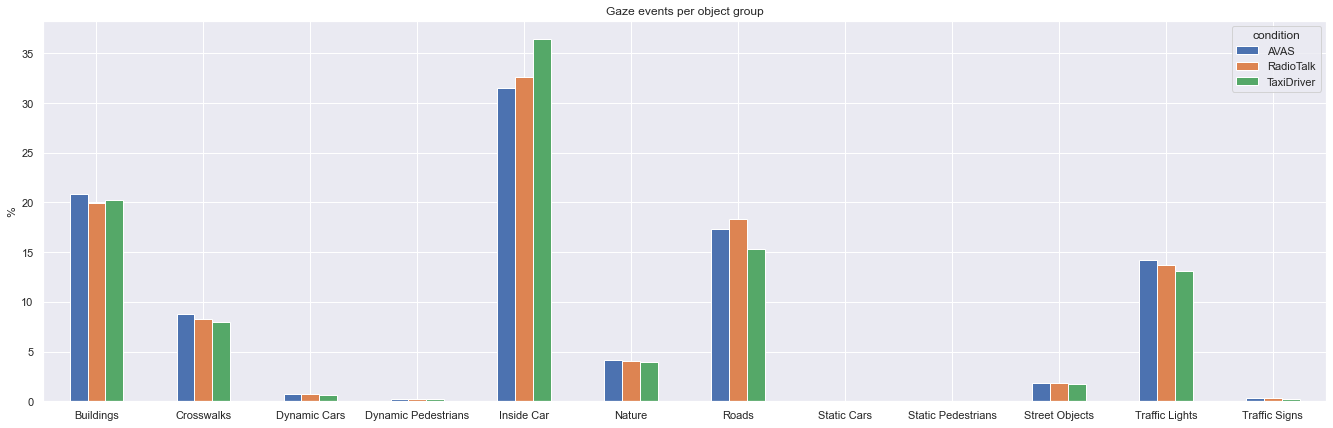

In [12]:
sns.set(rc={"figure.figsize": (23, 7)})

ax = test.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")

plt.title("Gaze events per object group")

plt.show()

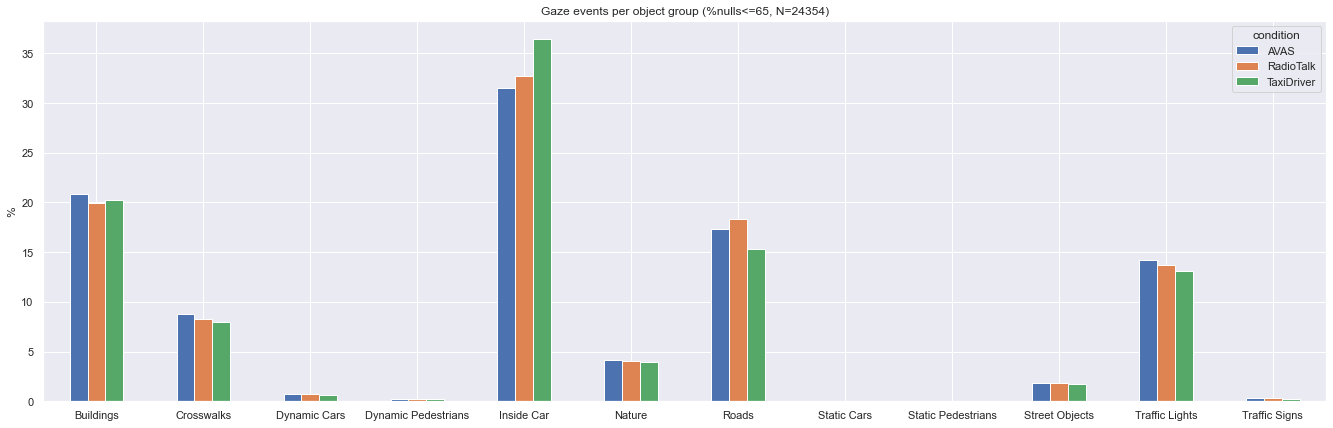

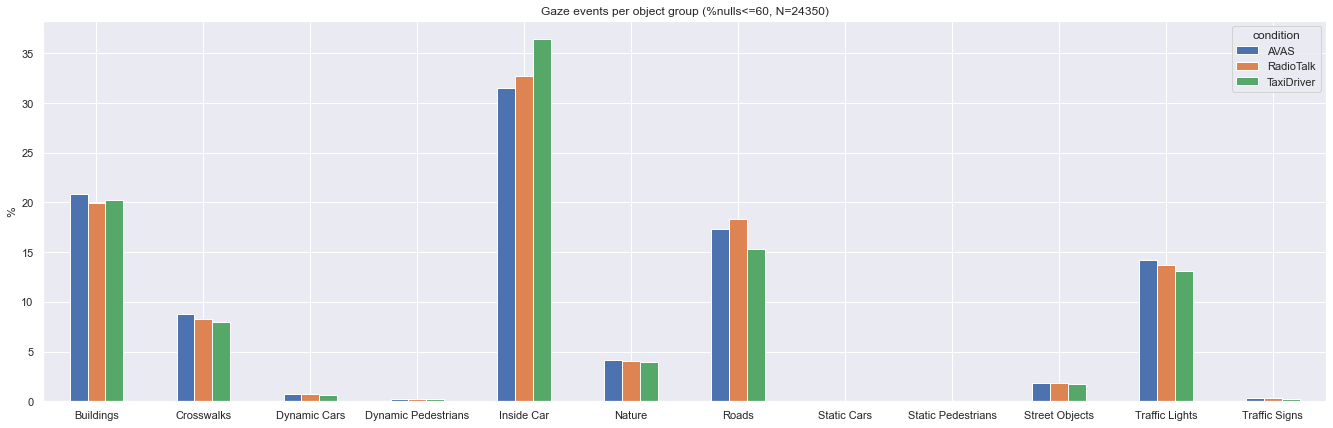

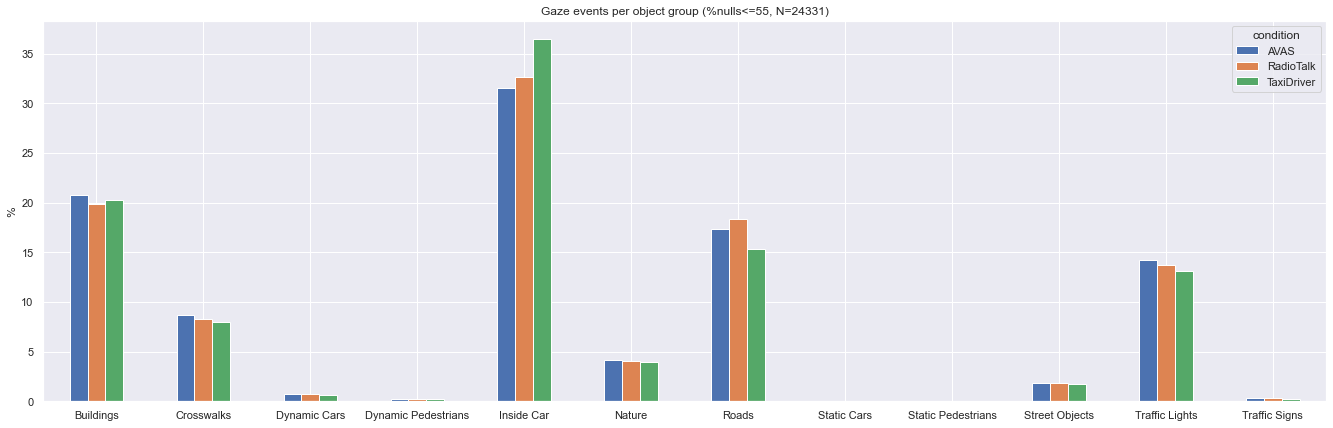

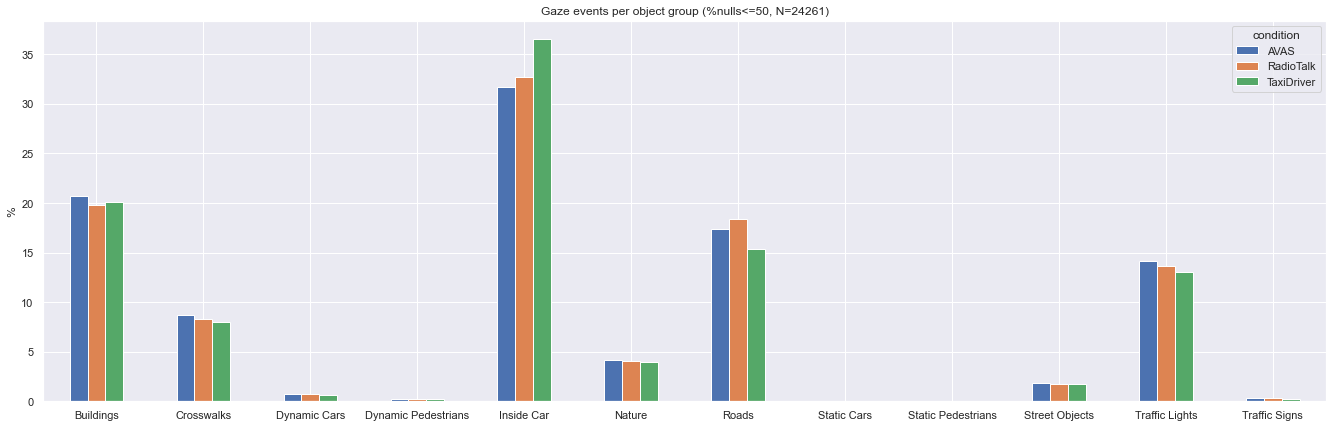

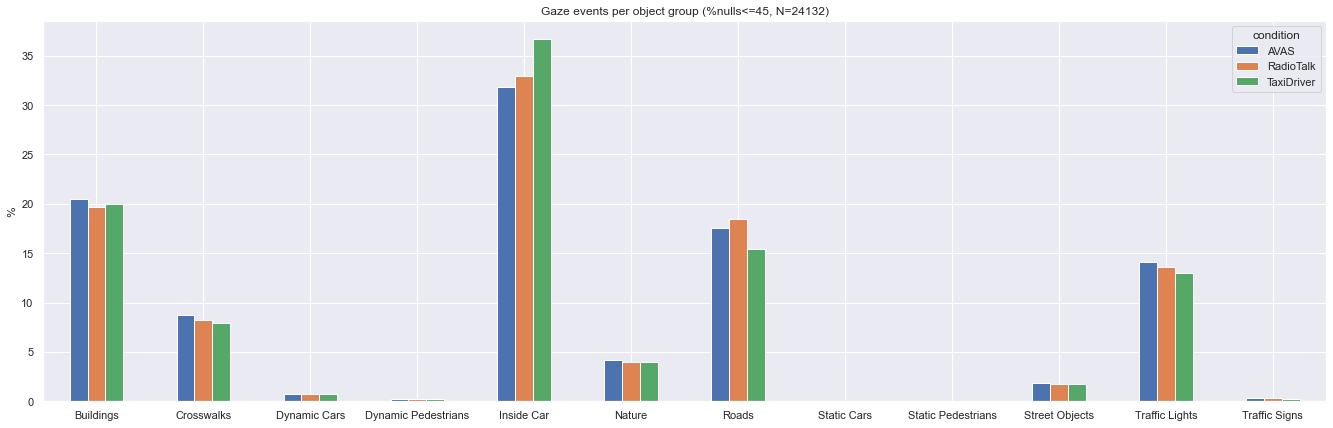

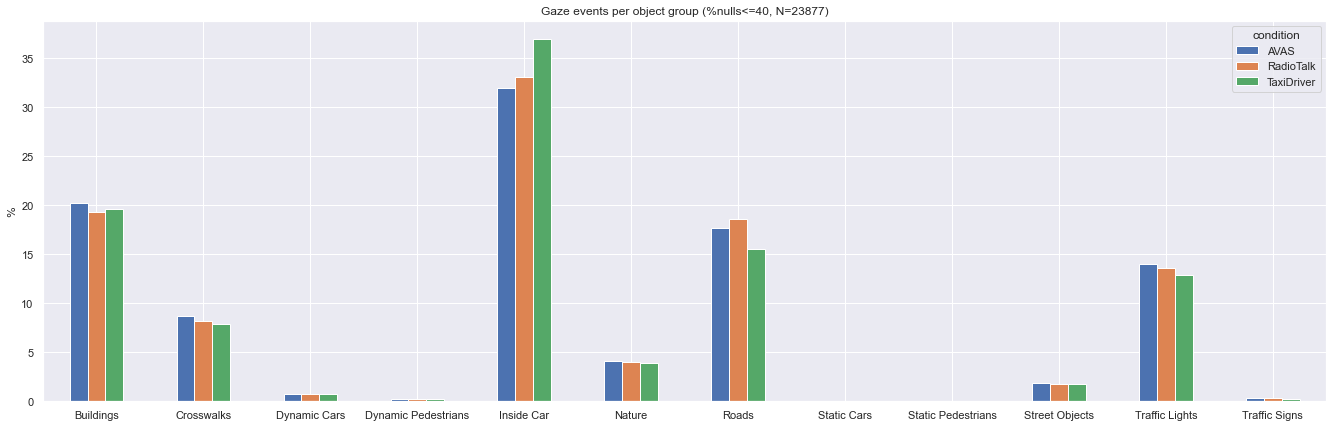

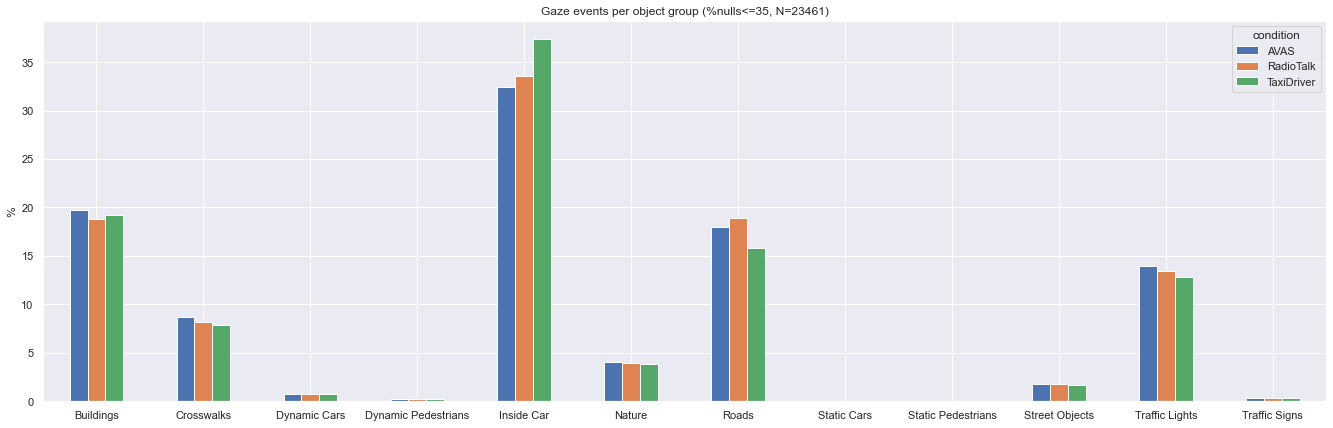

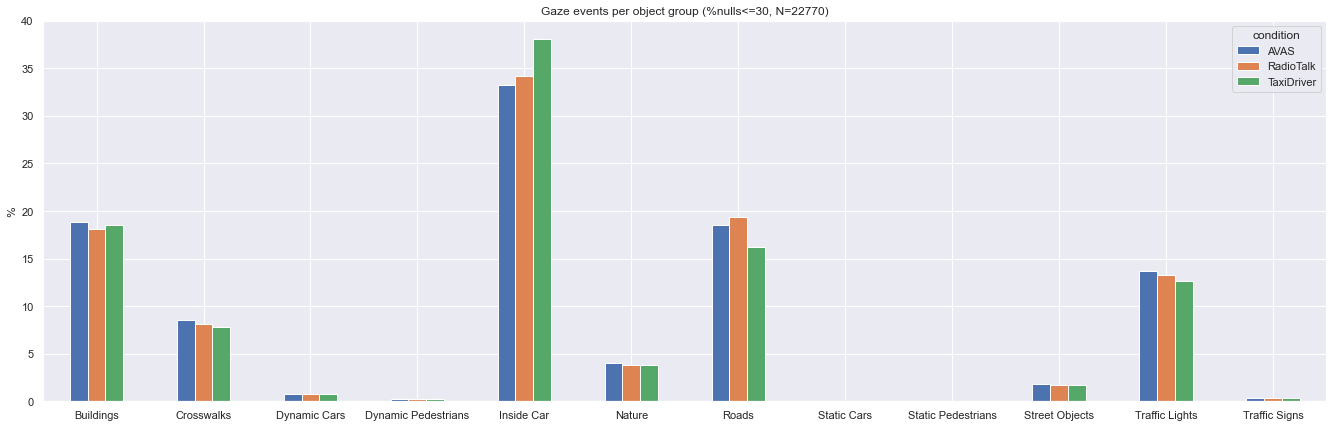

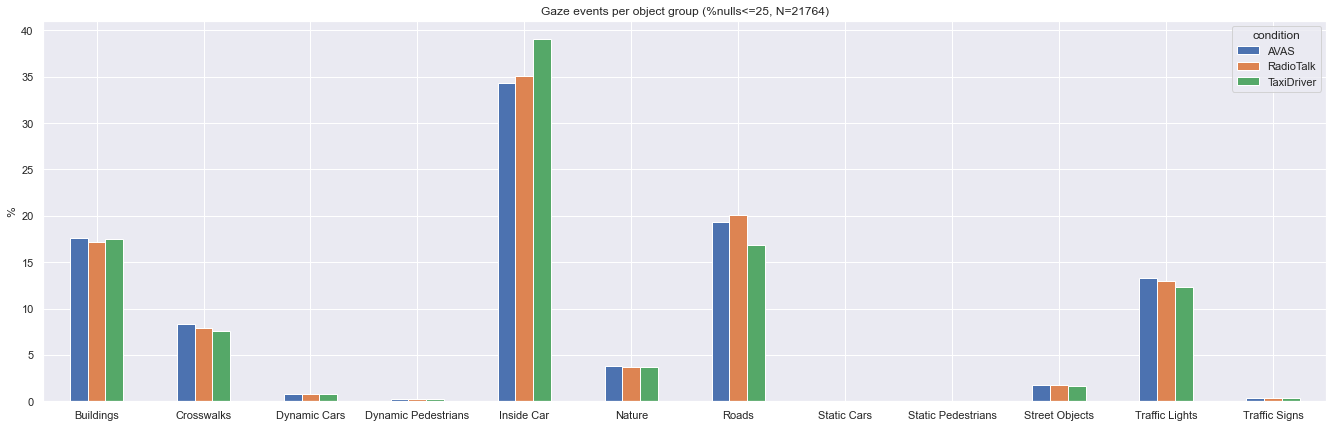

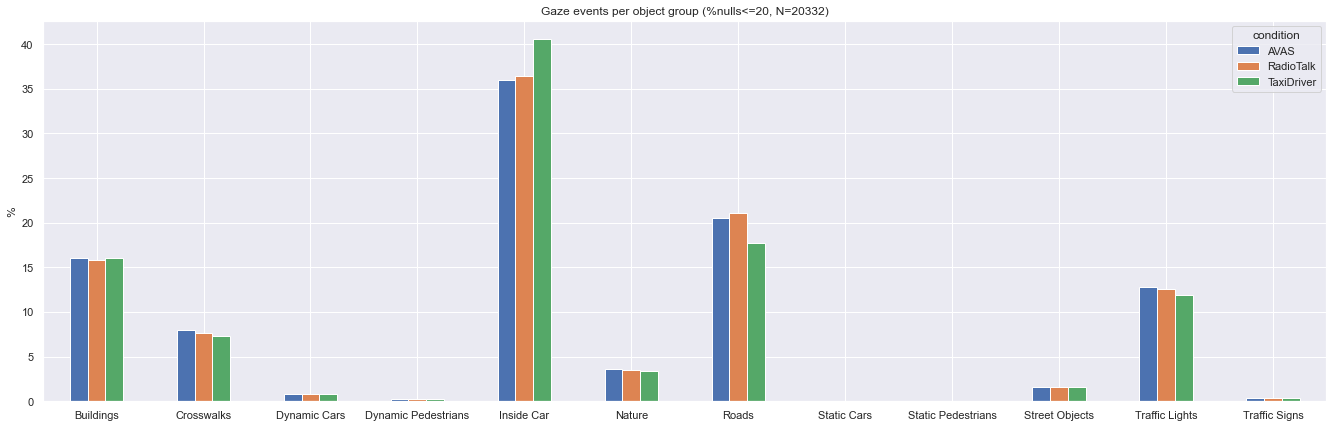

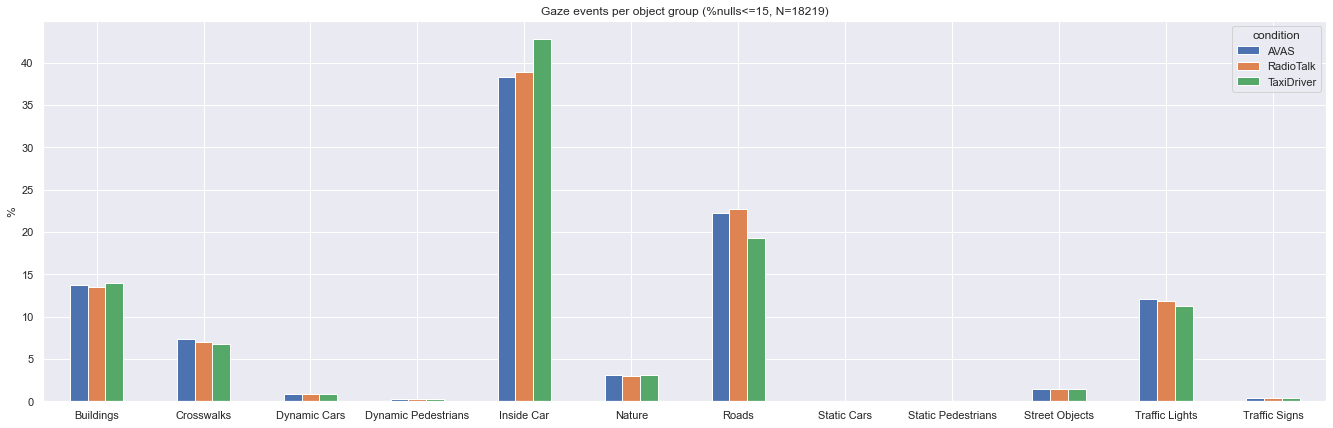

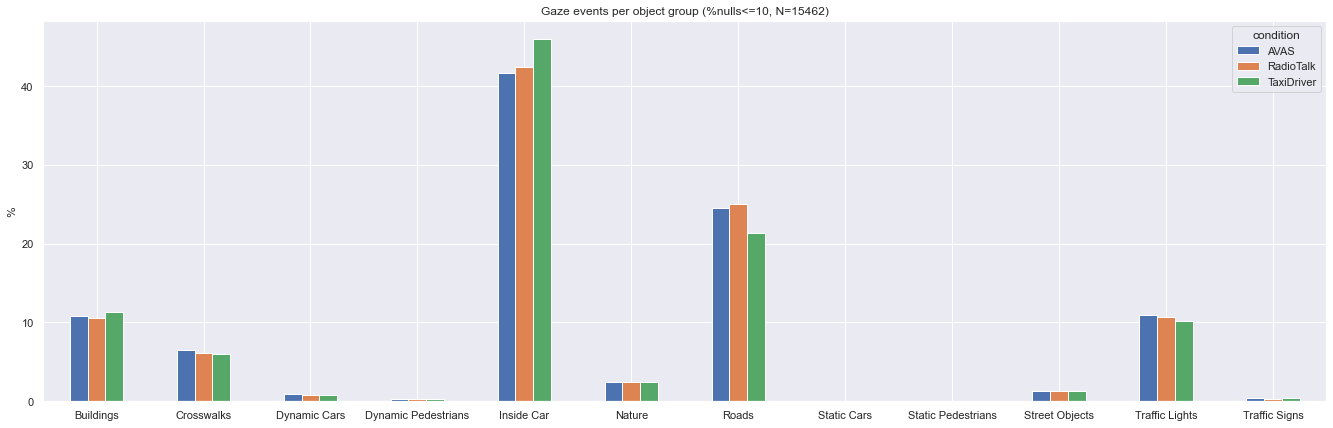

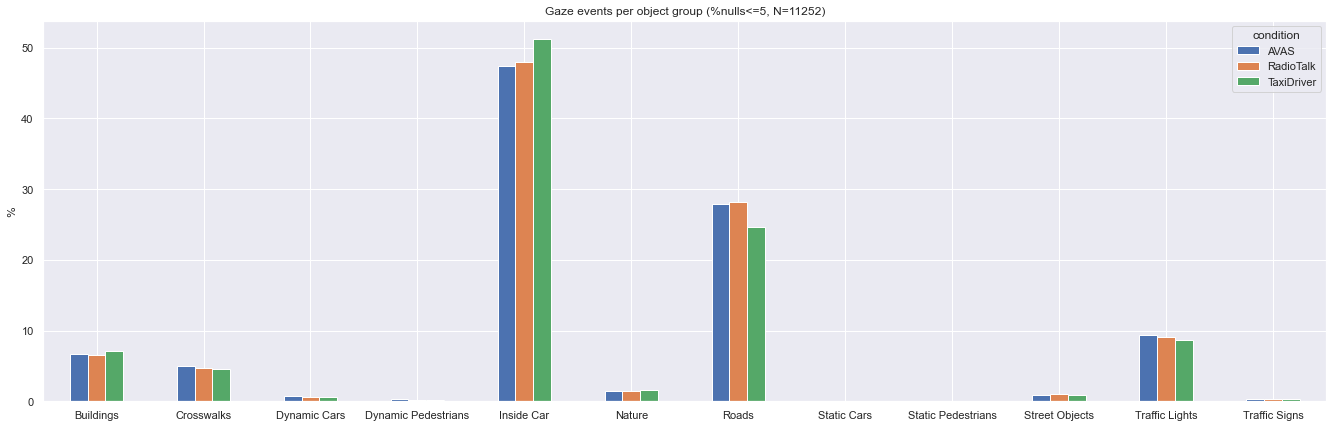

In [20]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")

start = 65

for i in range(0, int(start), 5):
    cur = start - i if start - i >= 1 else 0
    
    sel = parts[parts["nulls_%"] <= cur]
    sample_size = sel.index.size

    sns.set(rc={"figure.figsize": (23, 7)})

    ax = test.loc[sel.index].groupby(["condition"]).mean().transpose().plot.bar(rot=0)

    ax.set_ylabel("%")

    plt.title(f"Gaze events per object group (%nulls<={cur}, N={sample_size})")

    plt.show()